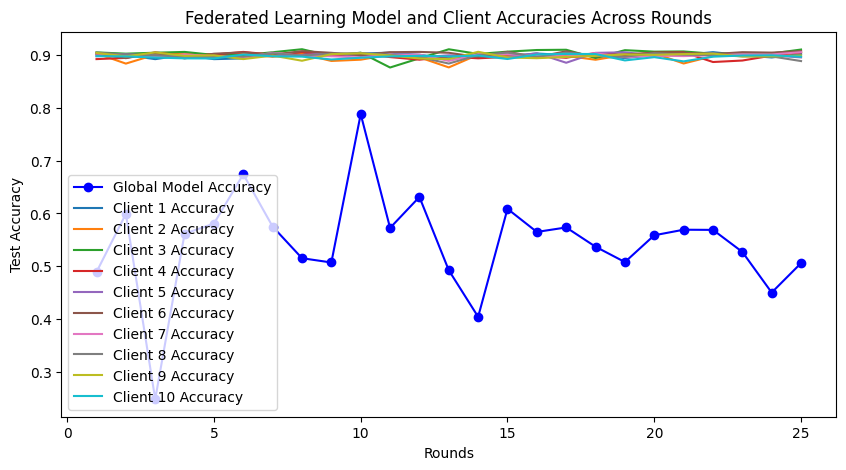

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the data

# Split the training data into multiple clients
num_clients = 10
client_data = np.array_split(x_train, num_clients)
client_labels = np.array_split(y_train, num_clients)

# Function to build a simple neural network model
def create_model():
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model on each client's data and return the weights and accuracy
def client_update(model, data, labels, epochs=1):
    model.fit(data, labels, epochs=epochs, verbose=1)
    return model.get_weights()

# Average the weights from all clients
def federated_average(weights):
    avg_weights = []
    for weight_tuple in zip(*weights):
        avg_weights.append(np.mean(weight_tuple, axis=0))
    return avg_weights

# Federated learning process
rounds = 25
global_accuracies = []
client_accuracies_per_round = []

for r in range(rounds):
    client_models = [create_model() for _ in range(num_clients)]
    client_weights, client_accuracies = [], []

    # Train each client model
    for i in range(num_clients):
        weights = client_update(client_models[i], client_data[i], client_labels[i])
        client_weights.append(weights)

        # Evaluate client model on the global test data
        _, client_test_acc = client_models[i].evaluate(x_test, y_test, verbose=0)
        client_accuracies.append(client_test_acc)

    # Store client accuracies for this round
    client_accuracies_per_round.append(client_accuracies)

    # Perform federated averaging
    avg_weights = federated_average(client_weights)

    # Create a new global model and set the averaged weights
    global_model = create_model()
    global_model.set_weights(avg_weights)

    # Evaluate the global model on test data
    _, global_test_acc = global_model.evaluate(x_test, y_test, verbose=1)
    global_accuracies.append(global_test_acc)

# Plotting global model accuracy across federated learning rounds
plt.figure(figsize=(10, 5))
plt.plot(range(1, rounds + 1), global_accuracies, 'bo-', label='Global Model Accuracy')

# Plotting each client's accuracy on the global test data across rounds
for i in range(num_clients):
    client_acc = [client_accuracies_per_round[round][i] for round in range(rounds)]
    plt.plot(range(1, rounds + 1), client_acc, label=f'Client {i+1} Accuracy')

plt.title('Federated Learning Model and Client Accuracies Across Rounds')
plt.xlabel('Rounds')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()


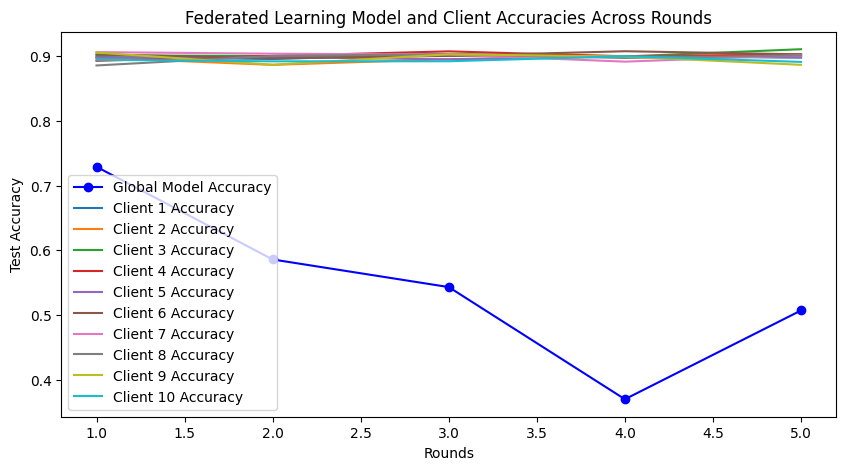

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the data

# Split the training data into multiple clients
num_clients = 10
client_data = np.array_split(x_train, num_clients)
client_labels = np.array_split(y_train, num_clients)

# Function to build a simple neural network model
def create_model():
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model on each client's data and return the weights
def client_update(model, data, labels, epochs=1):
    model.fit(data, labels, epochs=epochs, verbose=1)
    return model.get_weights()

# Weighted federated averaging
def federated_average(weights, client_sizes):
    total_size = np.sum(client_sizes)
    avg_weights = []
    for weight_tuple in zip(*weights):
        weighted_sum = np.sum([w * size / total_size for w, size in zip(weight_tuple, client_sizes)], axis=0)
        avg_weights.append(weighted_sum)
    return avg_weights

# Federated learning process
rounds = 5
global_accuracies = []
client_accuracies_per_round = []
client_sizes = [len(data) for data in client_data]

for r in range(rounds):
    client_models = [create_model() for _ in range(num_clients)]
    client_weights, client_accuracies = [], []

    # Train each client model
    for i in range(num_clients):
        weights = client_update(client_models[i], client_data[i], client_labels[i])
        client_weights.append(weights)

        # Evaluate client model on the global test data
        _, client_test_acc = client_models[i].evaluate(x_test, y_test, verbose=1)
        client_accuracies.append(client_test_acc)

    # Store client accuracies for this round
    client_accuracies_per_round.append(client_accuracies)

    # Perform weighted federated averaging
    avg_weights = federated_average(client_weights, client_sizes)

    # Create a new global model and set the averaged weights
    global_model = create_model()
    global_model.set_weights(avg_weights)

    # Evaluate the global model on test data
    _, global_test_acc = global_model.evaluate(x_test, y_test, verbose=0)
    global_accuracies.append(global_test_acc)

# Plotting global model accuracy across federated learning rounds
plt.figure(figsize=(10, 5))
plt.plot(range(1, rounds + 1), global_accuracies, 'bo-', label='Global Model Accuracy')

# Plotting each client's accuracy on the global test data across rounds
for i in range(num_clients):
    client_acc = [client_accuracies_per_round[round][i] for round in range(rounds)]
    plt.plot(range(1, rounds + 1), client_acc, label=f'Client {i+1} Accuracy')

plt.title('Federated Learning Model and Client Accuracies Across Rounds')
plt.xlabel('Rounds')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()
